# Examine the correlation between consistency and importance pattern similarity

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random
from tqdm import tqdm

from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
relations = ["P19", "P20", "P27", "P101", "P495", "P740", "P1376"]
model_name = "gpt2_xl"

data_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/RQ1"

In [3]:
data = pd.DataFrame()

for relation in relations:
    tmp_data = pd.read_csv(os.path.join(data_folder, model_name, f"{relation}.csv"))
    tmp_data["relation"] = relation
    data = data.append(tmp_data, ignore_index=True)
        
data

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,any,P19
1,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,Alexandra,False,False,0.017587,0.003975,False,0.995587,candidate,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,any,P19
3,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,Alexandra,False,False,0.017587,0.003594,False,0.996345,candidate,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63055,1023,1020,Rumbek,{} is the capital of,"{}, the capital city of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.003583,False,0.993998,candidate,P1376
63056,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",the,the,Lakes,False,False,0.025886,0.025681,True,0.999859,any,P1376
63057,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.006395,False,0.992868,candidate,P1376
63058,1025,1020,Rumbek,{} is the capital of,"{}, that is the capital city of",the,the,Lakes,False,False,0.025886,0.051186,True,0.999690,any,P1376


In [4]:
data.pred_type.value_counts()

any          45517
candidate    17543
Name: pred_type, dtype: int64

## Similarity values measured before filtering objects and TE thresholding

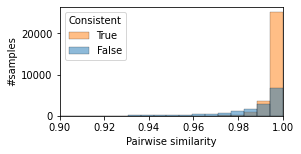

In [5]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=100)
plt.xlim([0.9, 1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sim_cons_any_te_any_obj.svg")
plt.show()

In [6]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.9922016037678018

In [7]:
data[data.pred_type=="any"].pairwise_sim.min()

0.4215492606163025

In [8]:
data[data.pred_type=="any"].pairwise_sim.std()

0.016303083396867445

## Get similarities and corresponding consistency values for pairwise comparisons between the LAMA template and other templates

**Important step:** Remove forbidden predictions to make certain we are only considering fact recall processes.

> Thoughts: Is "works in the field of [digital]" or "works in the field of [human]" ok?

In [9]:
forbidden_predictions = ["a", "the", "collaboration", "response", "public", '"', "order", "partnership", "honor", "AD", "open", "H", "age", "creating", "disgrace", "her", "his", "in", "left", "not", "providing", "tragedy", "which", "whom"]
print("Removing the forbidden predictions for the LAMA paraphrases...")
print(data[data.lama_answer.isin(forbidden_predictions)].lama_answer.value_counts())

forbidden_mask = (data.lama_answer.isin(forbidden_predictions))# | (data.sample_answer.isin(forbidden_predictions))
data = data[~(forbidden_mask)].reset_index(drop=True)
data

Removing the forbidden predictions for the LAMA paraphrases...
the              28327
a                 2814
public             282
response            64
collaboration       32
"                   24
honor               16
partnership         16
order               16
AD                   7
open                 6
H                    5
Name: lama_answer, dtype: int64


,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,any,P19
1,1,0,Allan Peiper,{} was born in,{} is originally from,London,Canada,Alexandra,False,False,0.017587,0.003975,False,0.995587,candidate,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,any,P19
3,2,0,Allan Peiper,{} was born in,{} was originally from,London,Canada,Alexandra,False,False,0.017587,0.003594,False,0.996345,candidate,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31446,1021,1020,Rumbek,{} is the capital of,{} is the capital city of,Slovenia,Slovenia,Lakes,False,False,0.011378,0.007738,True,0.983722,candidate,P1376
31447,1022,1020,Rumbek,{} is the capital of,"{}, the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.005172,False,0.996760,candidate,P1376
31448,1023,1020,Rumbek,{} is the capital of,"{}, the capital city of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.003583,False,0.993998,candidate,P1376
31449,1024,1020,Rumbek,{} is the capital of,"{}, that is the capital of",Slovenia,Ukraine,Lakes,False,False,0.011378,0.006395,False,0.992868,candidate,P1376


Check that the remaining predictions are ok...

In [10]:
pd.options.display.max_rows = 4000
print(data.lama_answer.value_counts())#.add(data.sample_answer.value_counts(), fill_value=0).head(1000)

18                3895
London            2464
Japan             1337
France            1198
Paris             1100
Germany           1074
Canada            1048
computer           888
2009               874
India              828
New                714
Chicago            698
Italy              685
Rome               630
Mexico             531
2011               386
Moscow             368
Tokyo              343
Sweden             327
England            305
psychology         300
Poland             298
2012               293
medicine           246
economics          234
2008               211
Berlin             210
2010               198
Denmark            188
17                 178
mathematics        168
Brooklyn           168
Israel             168
Brazil             166
Pakistan           165
Finland            164
Madrid             140
physics            138
digital            138
Greece             136
Iran               136
Norway             136
Australia          131
Russia     

In [11]:
test_token = "the"
data[(data.sample_answer==test_token) | (data.lama_answer==test_token)]

,sample_ix,lama_ix,subject,lama_template,sample_template,lama_answer,sample_answer,correct_answer,lama_correct,sample_correct,lama_te,sample_te,is_consistent,pairwise_sim,pred_type,relation
0,1,0,Allan Peiper,{} was born in,{} is originally from,New,the,Alexandra,False,False,0.023766,0.021967,False,0.998697,any,P19
2,2,0,Allan Peiper,{} was born in,{} was originally from,New,the,Alexandra,False,False,0.023766,0.018423,False,0.998855,any,P19
4,3,0,Allan Peiper,{} was born in,{} is native to,New,the,Alexandra,False,False,0.023766,0.022872,False,0.994816,any,P19
6,4,0,Allan Peiper,{} was born in,{} was native to,New,the,Alexandra,False,False,0.023766,0.016975,False,0.996224,any,P19
8,5,0,Allan Peiper,{} was born in,{} originated from,New,the,Alexandra,False,False,0.023766,0.015993,False,0.983260,any,P19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31144,773,768,Bamako,{} is the capital of,"{}, that is the capital city of",Mali,the,Mali,True,False,0.523068,0.308704,False,0.977363,any,P1376
31171,793,792,Harrisburg,{} is the capital of,{} is the capital city of,Pennsylvania,the,Pennsylvania,True,False,0.379509,0.357757,False,0.993783,any,P1376
31336,931,930,Nashville,{} is the capital of,{} is the capital city of,Tennessee,the,Tennessee,True,False,0.476995,0.394561,False,0.980626,any,P1376
31372,958,954,Saint Paul,{} is the capital of,"{}, that is the capital of",Minnesota,the,Minnesota,True,False,0.427549,0.257020,False,0.989695,any,P1376


## Similarity values measured before TE thresholding

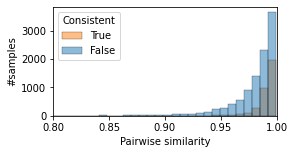

In [12]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=80)
plt.xlim([0.8,1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sim_cons_any_te.svg")
plt.show()

In [13]:
data[data.pred_type=="any"].pairwise_sim.mean()

0.98230348727838

In [14]:
data[data.pred_type=="any"].pairwise_sim.min()

0.4215492606163025

In [15]:
data[data.pred_type=="any"].pairwise_sim.std()

0.026020105593205667

## TE and consistency interaction

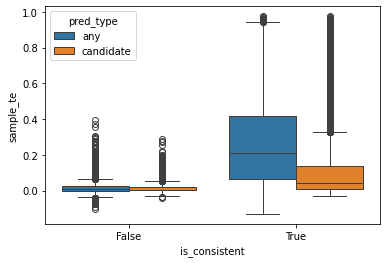

In [16]:
sns.boxplot(data=data, x="is_consistent", y="sample_te", hue="pred_type")
plt.show()

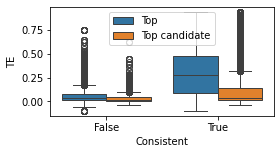

In [17]:
plt.figure(figsize=(4,2))
ax = sns.boxplot(data=data, x="is_consistent", y="lama_te", hue="pred_type")
plt.xlabel("Consistent")
plt.ylabel("TE")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Top", "Top candidate"])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/te_cons.svg")
plt.show()

In [18]:
data.groupby(["pred_type", "is_consistent"]).sample_te.count()

pred_type  is_consistent
any        False            10463
           True              3445
candidate  False             5692
           True             11851
Name: sample_te, dtype: int64

## TE threshold

To ensure that we only measure fact associations for a memory recall process, we restrict our analysis to samples for which perturbing the subject yields a lower probability of the traced object compared to the unperturbed case. I.e. the total effect as defined by Meng et al. is positive.

> We need to be able to show that we can perform causal tracing also for incorrect predictions. The ROME CT results by the ROME authors had a mean TE of 0.229, with minimum around -0.2 and maximum around 1. We match this by thresholding the TE of our CT results to be above 0.1.

In [19]:
te_thresh = 0.1
data = data[(data.sample_te>te_thresh) & (data.lama_te>te_thresh)]
print(f"{len(data)} data samples have a TE above 0.1")

5548 data samples have a TE above 0.1


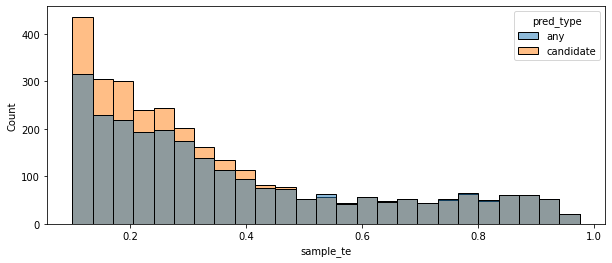

In [20]:
plt.figure(figsize=(10,4))
sns.histplot(data=data, x="sample_te", hue="pred_type")
plt.show()

In [21]:
data.groupby("pred_type")[["sample_te", "lama_te"]].agg(["mean", "count"])

sample_te         lama_te      
               mean count      mean count
pred_type                                
any        0.380810  2544  0.430536  2544
candidate  0.352712  3004  0.375312  3004

In [22]:
data.groupby("pred_type")[["sample_te", "lama_te"]].agg(["mean", "count"])

sample_te         lama_te      
               mean count      mean count
pred_type                                
any        0.380810  2544  0.430536  2544
candidate  0.352712  3004  0.375312  3004

The results for the LAMA template re-occurs for each paraphrase and needs to be de-duplicated.

In [23]:
data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.4007626285231159

In [37]:
data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.35252481416588827

In [39]:
len(data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_te)

620

## The makeup of the data

In [24]:
data[data.pred_type=="any"].relation.value_counts()

P27      1300
P1376     613
P740      389
P495       75
P19        75
P101       50
P20        42
Name: relation, dtype: int64

In [48]:
data[data.pred_type=="candidate"].relation.value_counts()

P27      2135
P1376     708
P495       56
P19        47
P101       29
P740       25
P20         4
Name: relation, dtype: int64

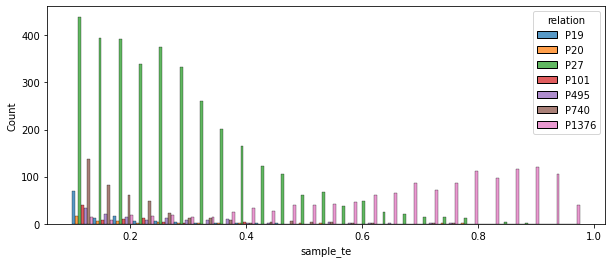

In [25]:
plt.figure(figsize=(10,4))
sns.histplot(data=data, x="sample_te", hue="relation", multiple="dodge")
plt.show()

## Consistency results
We are also interested in model consistency. We can here observe how the model is generally more consistent when we filter the output for candidates, but that it does not achieve perfect consistency. 

> Note that these consistency values only are measured for pairwise comparisons between the LAMA template and other paraphrases.

In [26]:
data.groupby("pred_type").is_consistent.agg(["mean", "count"])

,mean,count
pred_type,,
any,0.882075,2544
candidate,0.970373,3004


## Accuracy results
We show that a high TE value can be measured even when the model is not correct. For all results below the TE is higher than 0.1.

In [27]:
data.groupby("pred_type")[["lama_correct", "sample_correct"]].agg(["mean", "count"])

lama_correct       sample_correct      
                  mean count           mean count
pred_type                                        
any           0.683569  2544       0.617531  2544
candidate     0.812250  3004       0.800932  3004

Measure TE and correctness across LAMA templates. Since these are repeated pairwise we need to make sure that we do not double report them.

In [28]:
# number of LAMA queries across all included relations
data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean().lama_correct.count()

526

In [41]:
# number of LAMA queries across all included relations
data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean().lama_correct.sum()

485.0

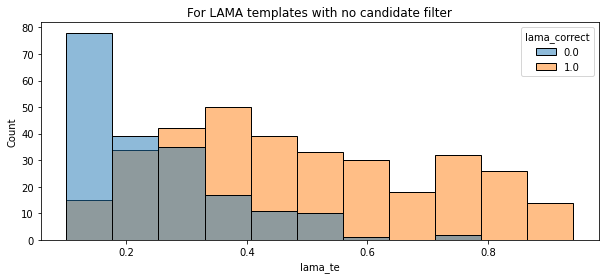

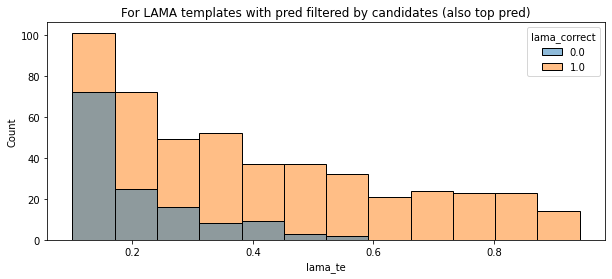

In [29]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct")
plt.title("For LAMA templates with no candidate filter")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"].groupby(["lama_ix", "relation"]).mean(), x="lama_te", hue="lama_correct")
plt.title("For LAMA templates with pred filtered by candidates (also top pred)")
plt.show()

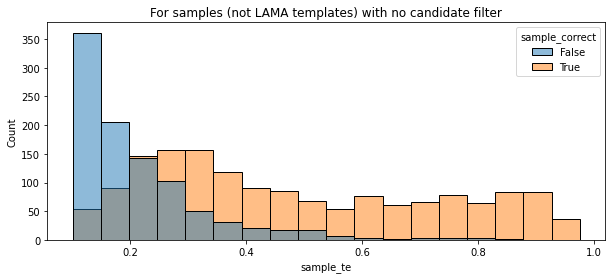

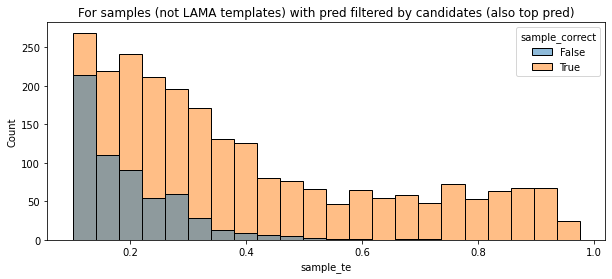

In [30]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"], x="sample_te", hue="sample_correct")
plt.title("For samples (not LAMA templates) with no candidate filter")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"], x="sample_te", hue="sample_correct")
plt.title("For samples (not LAMA templates) with pred filtered by candidates (also top pred)")
plt.show()

In [44]:
cols_subset = list(data.columns)
cols_subset.remove("pred_type")
cand_dups = data.duplicated(cols_subset)
#need to de-duplicate LAMA template results
data[~(cand_dups) & (data.pred_type=="candidate")].groupby(["lama_ix", "relation"]).mean().lama_te.mean()

0.21812908259359584

## Evaluate RQ1

We should be able to observe a correlation between consistent predictions and consistent fact recall, measured as similarity between extracted factual subject associations. 

We report the Spearman correlation between model consistency and extraction pattern similarity.

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[(data.pred_type=="any") & (data.pairwise_sim<0.95)], x="pairwise_sim", hue="is_consistent")
plt.show()

In [ ]:
plt.figure(figsize=(4,2))
sns.histplot(data=data[data.pred_type=="any"], x="pairwise_sim", hue="is_consistent", bins=80)
plt.xlim([0.8,1])
plt.xlabel("Pairwise similarity")
plt.ylabel("#samples")
plt.legend(title='Consistent', loc='upper left', labels=['True', 'False'])
plt.savefig("/cephyr/users/lovhag/Alvis/projects/rome/images/sim_cons.svg")
plt.show()

In [ ]:
data[data.pred_type=="any"].pairwise_sim.mean()

In [ ]:
data[data.pred_type=="any"].pairwise_sim.min()

In [ ]:
data[data.pred_type=="any"].pairwise_sim.std()

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=data[data.pred_type=="candidate"], x="pairwise_sim", hue="is_consistent")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=data[(data.pred_type=="candidate") & (data.pairwise_sim<0.95)], x="pairwise_sim", hue="is_consistent")
plt.show()

In [ ]:
test_data = data[data.pred_type=="any"].copy()

print(scipy.stats.spearmanr(test_data.is_consistent, 
                      test_data.pairwise_sim))
print(f"Number of samples: {len(test_data)}, of which {(len(test_data[test_data.is_consistent]))} are consistent.")

In [ ]:
test_data = data[data.pred_type=="candidate"].copy()

print(scipy.stats.spearmanr(test_data.is_consistent, 
                      test_data.pairwise_sim))
print(f"Number of samples: {len(test_data)}, of which {(len(test_data[test_data.is_consistent]))} are consistent.")

## Error analysis

In [ ]:
data[data.is_consistent==False].groupby(["lama_answer","sample_answer"]).agg({"lama_te": "mean", "sample_te": "mean", "pairwise_sim": ["mean","count"]})


Is it the case that the model for "the" or "a" sample predictions also ranks the LAMA predicted token highly?

In [ ]:
the_ixs = data[(data.is_consistent==False) & (data.sample_answer.isin(forbidden_predictions))][["relation","sample_ix"]]
data_mask = data.apply(lambda row: row.sample_ix in list(the_ixs[the_ixs.relation==row.relation].sample_ix), axis=1)
data[data_mask]

In [ ]:
data[(data.is_consistent==True) & (data.pairwise_sim<0.95)].groupby(["lama_answer","sample_answer"]).agg({"lama_te": "mean", "sample_te": "mean", "pairwise_sim": ["mean","count"]})
